/home/th/miniconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-12 00:38:36.619081: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-12 00:38:36.626854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760204316.636153    3919 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760204316.639244    3919 cuda_blas.cc:1418] Un

1. Đang load và chuẩn bị dữ liệu...
Chuẩn bị dữ liệu hoàn tất.

Bắt đầu huấn luyện model 'BasicAE'...
Epoch 10/100 | Train Loss: 0.014543 | Val Loss: 0.011858
Epoch 20/100 | Train Loss: 0.007677 | Val Loss: 0.014762
Epoch 30/100 | Train Loss: 0.007523 | Val Loss: 0.016791
Epoch 40/100 | Train Loss: 0.002794 | Val Loss: 0.003590
Epoch 50/100 | Train Loss: 0.001831 | Val Loss: 0.001781
Epoch 60/100 | Train Loss: 0.001649 | Val Loss: 0.001514
Epoch 70/100 | Train Loss: 0.001171 | Val Loss: 0.001178
Epoch 80/100 | Train Loss: 0.001132 | Val Loss: 0.001130
Epoch 90/100 | Train Loss: 0.001101 | Val Loss: 0.001080
Epoch 100/100 | Train Loss: 0.001082 | Val Loss: 0.001061
Huấn luyện hoàn tất trong 745.88 giây. Model tốt nhất đã lưu vào 'best_basic_ae.pth'.

Bắt đầu huấn luyện model 'ImprovedAnomalyAE'...
Epoch 10/150 | Train Loss: 0.202546 | Val Loss: 0.109441
Epoch 20/150 | Train Loss: 0.176892 | Val Loss: 0.098244
Epoch 30/150 | Train Loss: 0.165215 | Val Loss: 0.091185
Epoch 40/150 | Train 

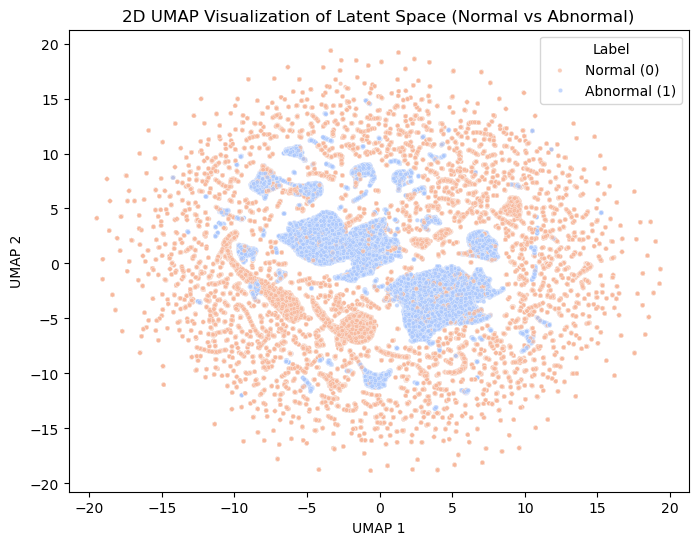

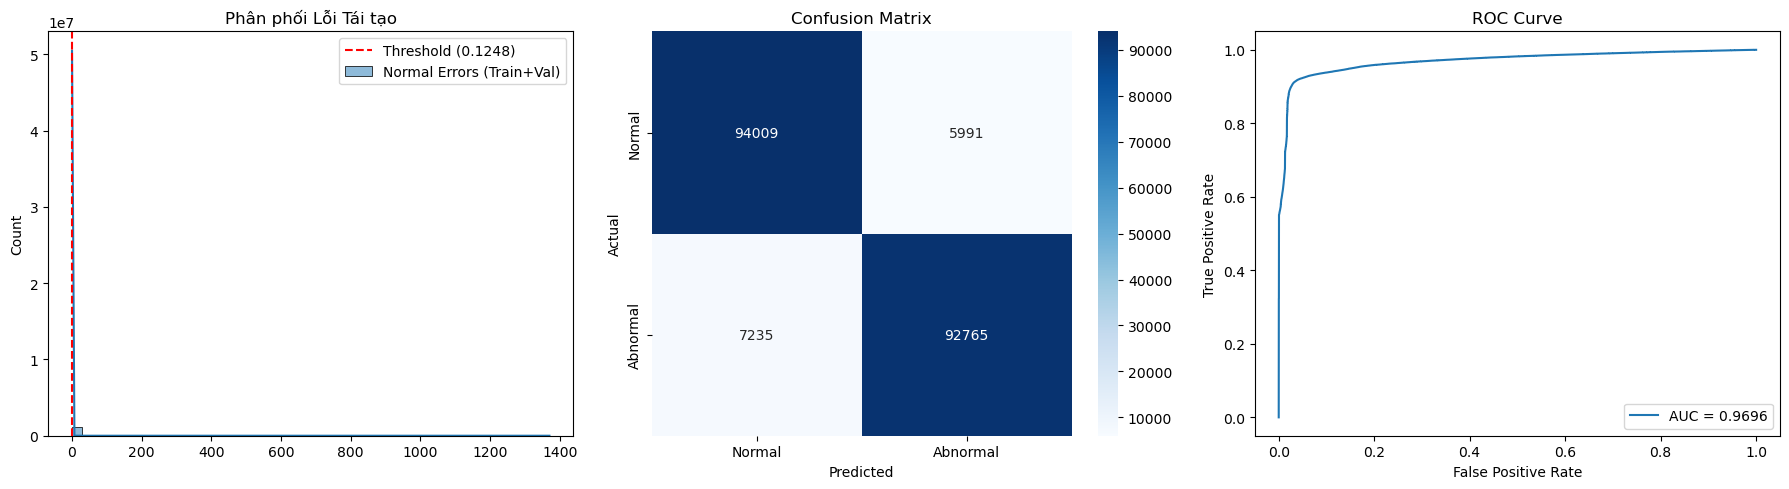

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import umap
import time
import warnings
warnings.filterwarnings('ignore')

# ===================================================================
# HÀM HUẤN LUYỆN TÁI SỬ DỤNG
# ===================================================================
def train_model(model, train_loader, val_loader, epochs, patience, learning_rate, model_save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    print(f"Bắt đầu huấn luyện model '{model.__class__.__name__}'...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for (data,) in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            reconstructed, _ = model(data) if isinstance(model, BasicAE) else (model(data), None)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (data,) in val_loader:
                data = data.to(device)
                reconstructed, _ = model(data) if isinstance(model, BasicAE) else (model(data), None)
                loss = criterion(reconstructed, data)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping được kích hoạt tại epoch {epoch+1}.")
            break
            
    end_time = time.time()
    print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây. Model tốt nhất đã lưu vào '{model_save_path}'.\n")
    model.load_state_dict(torch.load(model_save_path))
    return model

# ============================
# 1. Load và chuẩn bị dữ liệu
# ============================
print("1. Đang load và chuẩn bị dữ liệu...")
try:
    train_data_raw = pd.read_csv('unsupervised_dataset.csv')
    test_data_raw = pd.read_csv('evaluation_dataset.csv')
    
    X_train = train_data_raw.apply(pd.to_numeric, errors='coerce').fillna(0).values
    X_test = test_data_raw.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').fillna(0).values
    y_test = test_data_raw.iloc[:, -1].values
    y_test_binary = np.where(y_test == -1, 1, 0)
except Exception as e:
    print(f"Lỗi khi đọc file CSV: {e}")
    exit()

X_train_split, X_val_split = train_test_split(X_train, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)
X_test_scaled = scaler.transform(X_test)
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
BATCH_SIZE = 256
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=BATCH_SIZE, shuffle=False)
print("Chuẩn bị dữ liệu hoàn tất.\n")

# ============================
# 2. AutoEncoder giảm chiều
# ============================
class BasicAE(nn.Module):
    def __init__(self, input_dim=X_train.shape[1], latent_dim=12):
        super(BasicAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, 64), nn.ReLU(), nn.Linear(64, input_dim))
    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z

basic_ae = BasicAE()
basic_ae = train_model(basic_ae, train_loader, val_loader, epochs=100, patience=10, learning_rate=1e-3, model_save_path="best_basic_ae.pth")

basic_ae.eval()
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    _, latent_train = basic_ae(X_train_tensor.to(device))
    _, latent_val = basic_ae(X_val_tensor.to(device))
    _, latent_test = basic_ae(X_test_tensor.to(device))

latent_scaler = StandardScaler()
X_train_latent_scaled = latent_scaler.fit_transform(latent_train.cpu().numpy())
X_val_latent_scaled = latent_scaler.transform(latent_val.cpu().numpy())
X_test_latent_scaled = latent_scaler.transform(latent_test.cpu().numpy())
X_train_latent_tensor = torch.FloatTensor(X_train_latent_scaled)
X_val_latent_tensor = torch.FloatTensor(X_val_latent_scaled)
X_test_latent_tensor = torch.FloatTensor(X_test_latent_scaled)
train_latent_loader = DataLoader(TensorDataset(X_train_latent_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_latent_loader = DataLoader(TensorDataset(X_val_latent_tensor), batch_size=BATCH_SIZE, shuffle=False)

# ============================
# 3. AutoEncoder phát hiện bất thường
# ============================
# === THAY ĐỔI 1: QUAY LẠI KIẾN TRÚC MODEL HIỆU QUẢ HƠN ===
class ImprovedAnomalyAE(nn.Module):
    def __init__(self, input_dim=12, latent_dim=6):
        super(ImprovedAnomalyAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32), nn.BatchNorm1d(32), nn.LeakyReLU(0.1), nn.Dropout(0.2),
            nn.Linear(32, 16), nn.BatchNorm1d(16), nn.LeakyReLU(0.1),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16), nn.BatchNorm1d(16), nn.LeakyReLU(0.1),
            nn.Linear(16, 32), nn.BatchNorm1d(32), nn.LeakyReLU(0.1), nn.Dropout(0.2),
            nn.Linear(32, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))
# ========================================================

anomaly_ae = ImprovedAnomalyAE()
anomaly_ae = train_model(anomaly_ae, train_latent_loader, val_latent_loader, epochs=150, patience=15, learning_rate=1e-4, model_save_path="best_anomaly_ae.pth")

# ============================
# 4. Đánh giá mô hình
# ============================
print("4. Đánh giá mô hình...")
anomaly_ae.eval()
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reconstructed_train = anomaly_ae(X_train_latent_tensor.to(device))
    reconstructed_val = anomaly_ae(X_val_latent_tensor.to(device))
    train_errors = torch.mean((X_train_latent_tensor.to(device) - reconstructed_train)**2, dim=1).cpu().numpy()
    val_errors = torch.mean((X_val_latent_tensor.to(device) - reconstructed_val)**2, dim=1).cpu().numpy()
    reconstructed_test = anomaly_ae(X_test_latent_tensor.to(device))
    test_errors = torch.mean((X_test_latent_tensor.to(device) - reconstructed_test)**2, dim=1).cpu().numpy()

# === THAY ĐỔI 2: HẠ NGƯỠNG MỘT CÁCH QUYẾT LIỆT ĐỂ TĂNG RECALL ===
train_val_errors = np.concatenate([train_errors, val_errors])
# Bạn có thể thử các giá trị khác như 94.0, 93.5 để tìm điểm cân bằng tốt nhất
PERCENTILE_THRESHOLD = 94.0
threshold = np.percentile(train_val_errors, PERCENTILE_THRESHOLD)
# =================================================================
y_pred_binary = (test_errors > threshold).astype(int)

auc = roc_auc_score(y_test_binary, test_errors)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_binary, y_pred_binary, average='binary')

print(f"\n=== KẾT QUẢ ĐÁNH GIÁ (Threshold = {PERCENTILE_THRESHOLD}%) ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Threshold tối ưu: {threshold:.6f}\n")

# ============================
# 5. Trực quan hóa
# ============================
# (Phần này giữ nguyên không đổi)
print("5. Vẽ biểu đồ trực quan hóa...")
print("Đang giảm chiều bằng UMAP để trực quan hóa...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
latent_test_2d = reducer.fit_transform(X_test_latent_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_test_2d[:, 0], y=latent_test_2d[:, 1], hue=y_test_binary, palette='coolwarm', s=10, alpha=0.7)
plt.title('2D UMAP Visualization of Latent Space (Normal vs Abnormal)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label', labels=['Normal (0)', 'Abnormal (1)'])
plt.savefig('umap_latent_space_viz.png')
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(train_val_errors, bins=50, kde=True, label='Normal Errors (Train+Val)')
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Phân phối Lỗi Tái tạo')
plt.legend()
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(y_test_binary, test_errors)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig("final_evaluation_charts_recall_optimized.png")
plt.show()